<a href="https://colab.research.google.com/github/IsyrafD/DataEngineering/blob/main/Group_assignment_30__SEIS6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SCRAPING**

Data that is scraped from Al-Ikhsan Website:

Brand: The brand name of the product.<br>
Product Name: The name or title of the product. <br>
Price (RM): The price of the product in Malaysian Ringgit (RM). <br>
Discount (%): Any available discount percentage. <br>
Product Image URL: A link to the product's image. <br>
SKU: The product's stock-keeping unit (if available on the product page). <br>
Description: A detailed description of the product. <br>
Installment: Information about installment options for the product. <br>
Rating: Product rating, represented as full, half, and off stars. <br>
Reviews: User reviews of the product. <br>

In [7]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time

# Base URL for the product category
base_url = "https://al-ikhsan.com/collections/mens-lifestyle"

# Headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
}

# Number of pages to scrape
total_pages = 5

# Initialize an empty list to store data
data_list = []

# Loop through each page
for page in range(1, total_pages + 1):
    url = f"{base_url}?page={page}"
    print(f"Scraping page {page} from {url}...")

    try:
        # Request the page content
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an error for bad responses

        # Parse the page content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract product details
        products = soup.find_all("div", {"class": "product-item"})
        for product in products:
            try:
                # Extract data from the main page
                brand = product.find("p", {"class": "brandplp"}).text.strip() if product.find("p", {"class": "brandplp"}) else "N/A"
                product_name = product.find("p", {"class": "product-item__title"}).text.strip() if product.find("p", {"class": "product-item__title"}) else "N/A"
                price = product.find("span", {"class": "new-price"}).text.strip() if product.find("span", {"class": "new-price"}) else "N/A"
                discount = product.find("span", {"class": "sale-box"}).text.strip() if product.find("span", {"class": "sale-box"}) else "N/A"
                product_image = product.find("img")["src"] if product.find("img") else "N/A"
                product_link = product.find("a", {"class": "product-link"})["href"] if product.find("a", {"class": "product-link"}) else "N/A"

                # Full product URL
                product_url = f"https://al-ikhsan.com{product_link}"

                # Visit individual product page for additional details
                product_response = requests.get(product_url, headers=headers)
                if product_response.status_code == 200:
                    product_soup = BeautifulSoup(product_response.text, 'html.parser')

                    # Extract additional details
                    sku = product_soup.find("div", {"class": "product__block product__sku block-padding"}).text.strip() if product_soup.find("div", {"class": "product__block product__sku block-padding"}) else "N/A"
                    description = product_soup.find("div", {"class": "tab-content tab-content-0 current rte"}).text.strip() if product_soup.find("div", {"class": "tab-content tab-content-0 current rte"}) else "N/A"
                    installment = product_soup.find("div", {"style": "font-size:14px; text-align:left; color:#454545; padding-top:10px; padding-bottom:0px;"}).text.strip() if product_soup.find("div", {"style": "font-size:14px; text-align:left; color:#454545; padding-top:10px; padding-bottom:0px;"}) else "N/A"

                    # Improved Rating Calculation
                    stars = product_soup.find("div", {"class": "jdgm-rev-widg__summary-stars"})
                    if stars:
                        on_stars = len(stars.find_all("span", {"class": "jdgm-star jdgm--on"}))
                        half_stars = len(stars.find_all("span", {"class": "jdgm-star jdgm--half"}))
                        total_stars = len(stars.find_all("span", {"class": "jdgm-star"}))
                        rating = f"{on_stars} full, {half_stars} half, {total_stars - on_stars - half_stars} off"
                    else:
                        rating = "0 full, 0 half, 5 off"

                    # Reviews
                    reviews = product_soup.find("div", {"class": "jdgm-rev__body"}).text.strip() if product_soup.find("div", {"class": "jdgm-rev__body"}) else "N/A"
                else:
                    sku = description = installment = rating = reviews = "N/A"

                # Append data to the list
                data_list.append({
                    "Brand": brand,
                    "Product Name": product_name,
                    "Price (RM)": price,
                    "Discount (%)": discount,
                    "Product Image URL": product_image,
                    "SKU": sku,
                    "Description": description,
                    "Installment": installment,
                    "Rating": rating,
                    "Reviews": reviews,
                })

            except Exception as product_error:
                print(f"Error processing product: {product_error}")

        # Pause between requests to avoid overwhelming the server
        time.sleep(2)

    except Exception as page_error:
        print(f"Error processing page {page}: {page_error}")

# Convert list to DataFrame
data_df = pd.DataFrame(data_list)

# Replace 'N/A' with a more readable format
data_df.fillna("Not Available", inplace=True)

# Reorder columns to make the DataFrame more composed
data_df = data_df[[
    "Brand", "Product Name", "Price (RM)", "Discount (%)", "Product Image URL",
     "SKU", "Description", "Installment", "Rating", "Reviews"
]]

# Save to CSV with better formatting
csv_file_name = "alikhsan.csv"
if not data_df.empty:
    data_df.to_csv(csv_file_name, index=False)
    print(f"Data successfully saved to {csv_file_name}")
else:
    print("No data scraped. CSV file not created.")

# Display the DataFrame with a well-formatted layout
print(data_df.head())


Scraping page 1 from https://al-ikhsan.com/collections/mens-lifestyle?page=1...
Scraping page 2 from https://al-ikhsan.com/collections/mens-lifestyle?page=2...
Scraping page 3 from https://al-ikhsan.com/collections/mens-lifestyle?page=3...
Scraping page 4 from https://al-ikhsan.com/collections/mens-lifestyle?page=4...
Scraping page 5 from https://al-ikhsan.com/collections/mens-lifestyle?page=5...
Data successfully saved to alikhsan.csv
    Brand                                       Product Name Price (RM)  \
0    NIKE  NIKE COURT VISION LOW NEXT NATURE MEN'S SHOES ...   RM275.00   
1    PUMA  PUMA Court Classic Vulcanized FS Men's Sneaker...   RM167.30   
2    NIKE                  NIKE AIR MAX SC MEN'S SHOES WHITE   RM179.40   
3  ADIDAS      Adidas Cloudfoam Go Lounger Men's Shoes Black   RM223.20   
4    NIKE              Nike Full Force Low Men's Shoes White   RM316.00   

  Discount (%)                                  Product Image URL  \
0          N/A  //al-ikhsan.com/cdn/shop

# **Data Cleaning**
1. Sorting the Data

*   Step: The data is sorted by "Brand" and "Product Name" in ascending order.
*   Purpose: Sorting ensures the data is organized for better readability and easier analysis.

2. Standardizing Capitalization
*   Step: The "Brand" and "Product Name" columns are standardized by converting all text to title case (capitalizing the first letter of each word).
*  Purpose: This removes inconsistencies in capitalization (e.g., "nike" becomes "Nike"), making the data uniform

3. Converting Prices to Numerical Format
* Step: The "Price (RM)" column is cleaned by removing non-numeric characters (e.g., "RM" and commas) and converted to a float type.
* Purpose: This converts prices into a numeric format for easier calculations and analysis (e.g., finding average price).

4. Cleaning the Installment Column
* Step: The word "with" is removed, and leading/trailing whitespaces are stripped.
* Purpose: To standardize and simplify the installment descriptions.

5. Reformating the Rating Column
* Step: The rating column, initially containing separate values for full, half, and off stars, is converted into a single numerical format (e.g., "4.5/5").
* Purpose: To provide a user-friendly representation of product ratings.

6. Cleaning the Reviews Column
* Step: The reviews are cleaned by:
     * Decoding emojis (if present).
     * Counting thumbs-up emojis (e.g., "👍").
     * Removing non-ASCII characters and stripping whitespace.
* Purpose: To make the reviews readable and summarize them (e.g., "Thumbs up x2").

7. Handling Missing and Empty Discount Values
* Step: Empty or missing "Discount (%)" values are replaced with "No Discount". The percentage sign (%) is removed, and valid values are converted to numeric format.
* Purpose: To handle missing data and allow mathematical operations (e.g., average discount).

**Techniques Used in Data Cleaning**
1. Text Normalization: Standardizing capitalization and removing unwanted characters.
2. Type Conversion: Converting data types (e.g., prices to float, ratings to numerical scales).
3. Missing Value Handling: Replacing missing or empty values with defaults (e.g., "N/A" or "No Discount").
4. Regex (Regular Expressions): Used for pattern matching and cleaning text (e.g., removing "RM" and non-ASCII characters).
5. String Operations: Applied for text formatting, trimming, and replacing unwanted content.
6. Error Handling: Try-except blocks ensure the cleaning process continues despite unexpected data formats.

In [2]:
import pandas as pd
import re

# Load the scraped data
data_df = pd.read_csv("alikhsan.csv")

# 1. Sort the DataFrame by Brand and Product Name in ascending order
data_df.sort_values(by=["Brand", "Product Name"], inplace=True)

# 2. Standardize capitalization for Brand and Product Name
data_df["Brand"] = data_df["Brand"].str.title().fillna("N/A")
data_df["Product Name"] = data_df["Product Name"].str.title().fillna("N/A")

# 3. Convert Price (RM) to numerical
data_df["Price (RM)"] = data_df["Price (RM)"].replace({"RM": "", ",": ""}, regex=True).astype(float)

# 4. Clean the Installment column
data_df["Installment"] = data_df["Installment"].str.replace("with", "", regex=False).str.strip().fillna("N/A")

# 5. Reformat the Rating column
def convert_rating(rating):
    if rating == "No Rating":
        return "No Rating"
    try:
        parts = rating.split(",")
        full = int(parts[0].split()[0])  # Extract number of full stars
        half = int(parts[1].split()[0])  # Extract number of half stars
        off = int(parts[2].split()[0])  # Extract number of off stars
        if full == 0 and half == 0 and off == 5:
            return "No Rating"
        total_stars = full + (half * 0.5)  # Calculate total stars
        return f"{total_stars}/5"
    except Exception:
        return "No Rating"

data_df["Rating"] = data_df["Rating"].apply(convert_rating).fillna("N/A")

# 6. Clean the Reviews column
def clean_reviews(review):
    if pd.isna(review) or review == "":
        return "No Review"
    try:
        review = review.decode('utf-8')  # Decode emojis
    except (UnicodeDecodeError, AttributeError):
        pass
    thumbs_up_count = review.count("👍")
    if thumbs_up_count > 0:
        return f"Thumbs up x{thumbs_up_count}"

    # Remove other unreadable special characters
    review = re.sub(r"[^\x00-\x7F]+", "", review)  # Remove non-ASCII characters
    return review.strip() or "No Review"

data_df["Reviews"] = data_df["Reviews"].apply(clean_reviews).fillna("No Review")

# 7. Handle missing or empty values in Discount column and remove '%' sign
data_df["Discount (%)"] = data_df["Discount (%)"].fillna("No Discount").replace("", "No Discount")

# Remove '%' and convert to numeric, or leave "No Discount" as is
data_df["Discount (%)"] = data_df["Discount (%)"].apply(lambda x: float(x.replace('%', '')) if isinstance(x, str) and '%' in x else x)

# Save the cleaned data to a new CSV file
cleaned_csv_file_name = "alikhsancleaned.csv"
data_df.to_csv(cleaned_csv_file_name, index=False)
print(f"Cleaned data successfully saved to {cleaned_csv_file_name}")

# Display the cleaned DataFrame
data_df.head()


Cleaned data successfully saved to alikhsancleaned.csv


,Brand,Product Name,Price (RM),Discount (%),Product Image URL,SKU,Description,Installment,Rating,Reviews
28,Adidas,Adidas Men Coreracer Shoes Lifestyle Black,114.5,50.0,//al-ikhsan.com/cdn/shop/files/f_x_fx3593_f.jp...,SKU: FX3593-8,The adidas Coreracer Shoes strike a perfect ba...,3 payments of RM38.16,No Rating,No Review
50,Adidas,Adidas Nebzed Cloudfoam Men'S Shoes Black,149.5,50.0,//al-ikhsan.com/cdn/shop/files/g_x_gx4275_f.jp...,SKU: GX4275-6,PRODUCT DESCRIPTIONS\nEVERYDAY LIGHTWEIGHT SHO...,3 payments of RM49.83,No Rating,No Review
51,Adidas,Adidas Nebzed Cloudfoam Men'S Shoes Black,149.5,50.0,//al-ikhsan.com/cdn/shop/files/g_x_gx4274_f.jp...,SKU: GX4274-6,PRODUCT DESCRIPTIONS\nEVERYDAY LIGHTWEIGHT SHO...,3 payments of RM49.83,5.0/5,Veryy good
30,Adidas,Adidas Showtheway 2.0 Men S Shoes,206.1,10.0,//al-ikhsan.com/cdn/shop/files/g_y_gy6348_f.jp...,SKU: GY6348-10,PRODUCT DESCRIPTIONS\nRUNNING SHOES FOR ALL DA...,3 payments of RM68.70,No Rating,No Review
31,Adidas,Adidas Showtheway 2.0 Men S Shoes,114.5,50.0,//al-ikhsan.com/cdn/shop/files/g_y_gy6346_f.jp...,SKU: GY6346-6H,PRODUCT DESCRIPTIONS\nRUNNING SHOES FOR ALL DA...,3 payments of RM38.16,No Rating,No Review


**Data Visualisation**

visualisation before cleaning
(rating)

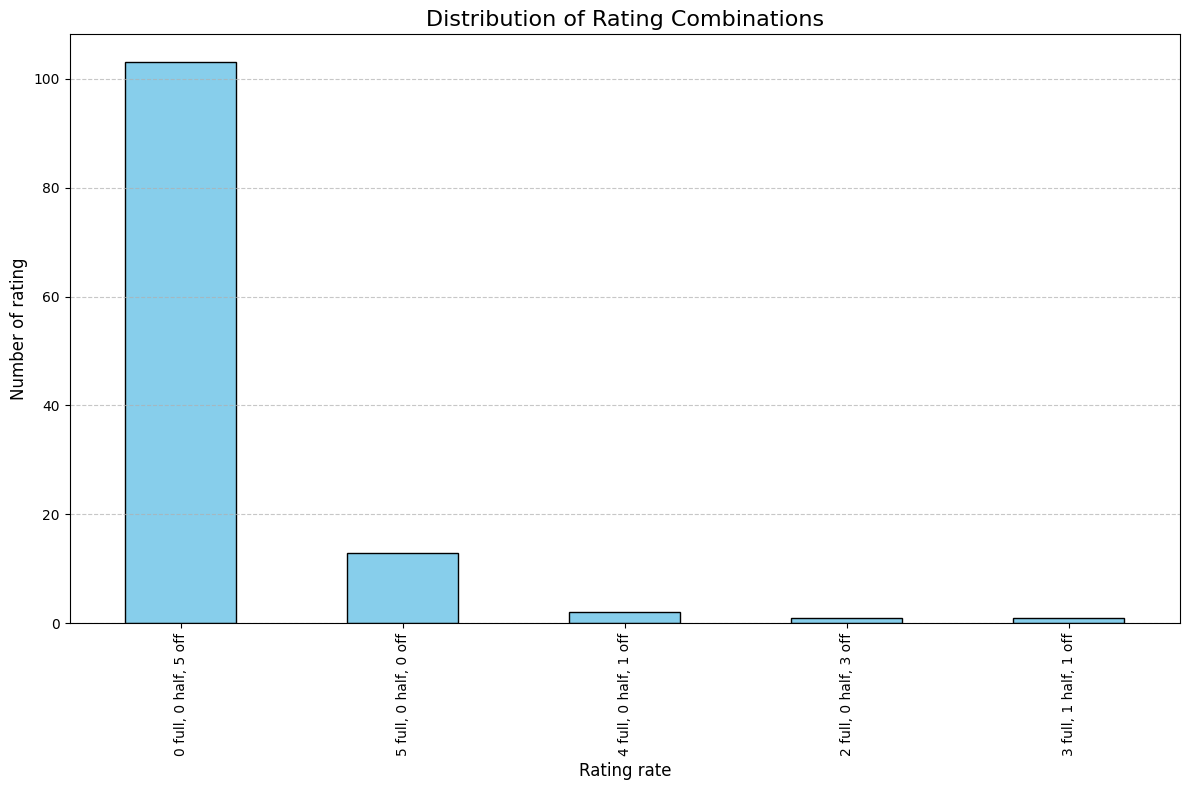

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("alikhsan.csv")

# Count occurrences of each unique "Rating" combination
rating_counts = df['Rating'].value_counts()

# Plot the data
plt.figure(figsize=(12, 8))
rating_counts.plot(kind='bar', color='skyblue', edgecolor="black")
plt.title('Distribution of Rating Combinations', fontsize=16)
plt.xlabel('Rating rate', fontsize=12)
plt.ylabel('Number of rating', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


visualisation after cleaning
(rating)

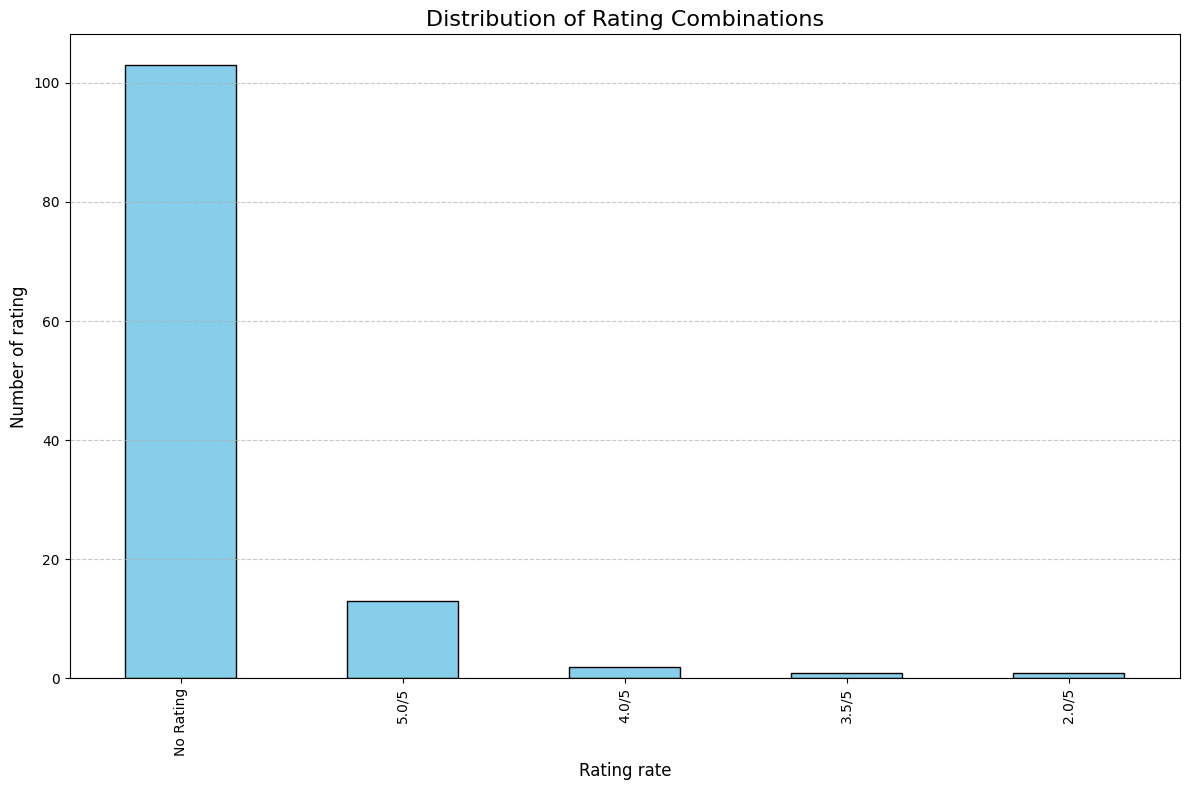

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("alikhsancleaned.csv")

# Count occurrences of each unique "Rating" combination
rating_counts = df['Rating'].value_counts()

# Plot the data
plt.figure(figsize=(12, 8))
rating_counts.plot(kind='bar', color='skyblue', edgecolor="black")
plt.title('Distribution of Rating Combinations', fontsize=16)
plt.xlabel('Rating rate', fontsize=12)
plt.ylabel('Number of rating', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Visualisation before cleaning (discount)

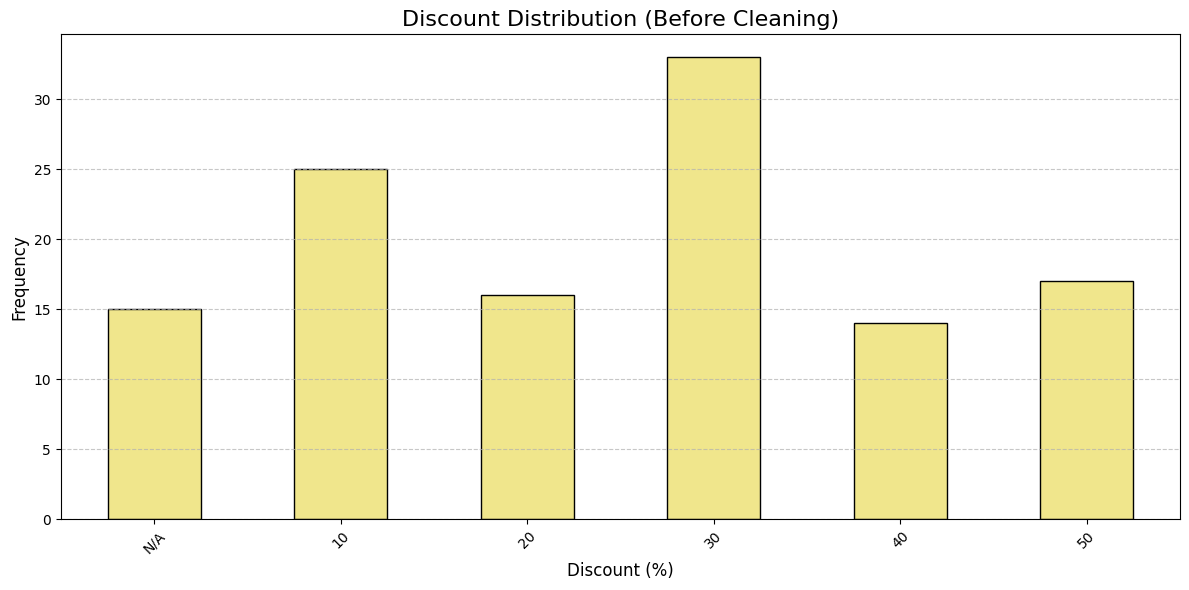

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset before cleaning
before_cleaning = pd.read_csv("alikhsan.csv")

# Replace 'N/A' with a category for visualization and handle '%' signs
before_cleaning["Discount (%)"] = before_cleaning["Discount (%)"].replace("N/A", "N/A").fillna("N/A")
before_cleaning["Discount (%)"] = before_cleaning["Discount (%)"].str.replace("%", "").astype(str)

# Define the custom order of the x-axis
discount_order = ['N/A', '10', '20', '30', '40', '50']

# Reorder the data according to the custom order
before_cleaning["Discount (%)"] = pd.Categorical(before_cleaning["Discount (%)"], categories=discount_order, ordered=True)

# Plot the data
plt.figure(figsize=(12, 6))
before_cleaning["Discount (%)"].value_counts().sort_index().plot(kind="bar", color="khaki", edgecolor="black")
plt.title("Discount Distribution (Before Cleaning)", fontsize=16)
plt.xlabel("Discount (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


Visualisation after cleaning (discount)

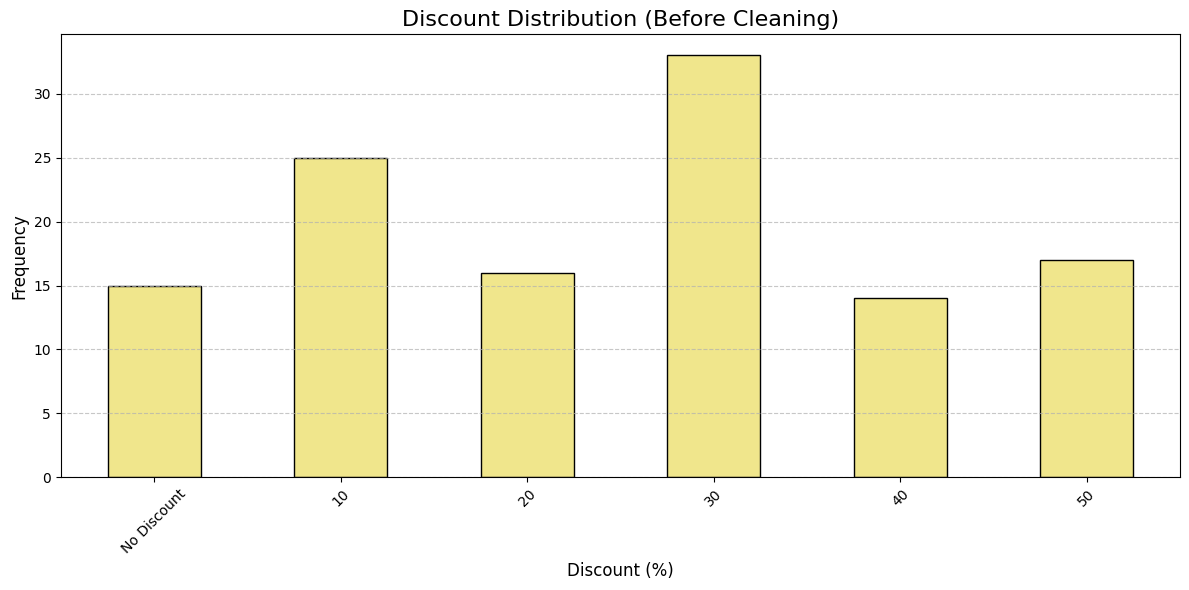

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset before cleaning
before_cleaning = pd.read_csv("alikhsan.csv")

# Replace 'N/A' with a category for visualization and handle '%' signs
before_cleaning["Discount (%)"] = before_cleaning["Discount (%)"].replace("No Discount", "No Discount").fillna("No Discount")
before_cleaning["Discount (%)"] = before_cleaning["Discount (%)"].str.replace("%", "").astype(str)

# Define the custom order of the x-axis
discount_order = ['No Discount', '10', '20', '30', '40', '50']

# Reorder the data according to the custom order
before_cleaning["Discount (%)"] = pd.Categorical(before_cleaning["Discount (%)"], categories=discount_order, ordered=True)

# Plot the data
plt.figure(figsize=(12, 6))
before_cleaning["Discount (%)"].value_counts().sort_index().plot(kind="bar", color="khaki", edgecolor="black")
plt.title("Discount Distribution (Before Cleaning)", fontsize=16)
plt.xlabel("Discount (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


# **Before Cleaning (Visualizations):**
1. Rating Distribution:

* Fragmented "Rating" values (e.g., "3 full, 1 half, 1 off").
* Hard to interpret the rating data due to inconsistent formatting.
2. Discount Distribution:

* "Discount (%)" included inconsistent values like "N/A" and unclean "%."
* Unordered categories, making it difficult to analyze discount trends.


# **After Cleaning (Visualizations):**
1. Rating Distribution:

* Reformatted ratings into a clear scale (e.g., "4.5/5").
* Bar chart shows the frequency of each rating combination, making trends easy to spot.
2. Discount Distribution:

* Cleaned and standardized "Discount (%)" values (e.g., "No Discount," "10," "20").
* Bar chart with a custom order (logical sequence) for discount categories for better interpretation.